In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from tqdm import tqdm
from torch.optim import Adam


**Подготовка данных**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Классы
classes = ('airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person')

#Отображение изображений
def showPict(images, labels, n=8):
    plt.figure(figsize=(12, 12))
    for i, image in enumerate(images[:n]):
        plt.subplot(n, n, i + 1)
        image = image/ 2 + 0.5
        plt.imshow(image.numpy().transpose((1, 2, 0)).squeeze())
    print(' '.join('%5s     ' % classes[label] for label in labels[:n]))

batchSize = 4

In [ ]:
#Преобразуем все изображения
transform = transforms.Compose(
    [transforms.Resize((64,64)),  #размер
     transforms.ToTensor(),   #перевод в формат тензор
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]) #нормализация

#загружаем датасет
df = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/ns/natural_images', transform=transform)

trainSize = int(0.8 * len(df))
testSize = len(df) - trainSize
trainSet, testSet = torch.utils.data.random_split(df, [trainSize, testSize])

trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=batchSize, shuffle=True, num_workers=0)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=batchSize, shuffle=True, num_workers=0)

  car      motorbike        car      airplane     


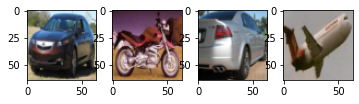

In [ ]:
#загрузчик
images, labels = next(iter(trainLoader))
showPict(images, labels)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


**Архитектура 1**

In [ ]:
class convNet1(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv0 = nn.Conv2d(3, 32, 3, stride = 1, padding = 0)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(32, 32, 3, stride = 1, padding = 0)
        self.conv2 = nn.Conv2d(32, 32, 3, stride = 1, padding = 0)
        self.conv3 = nn.Conv2d(32, 32, 3, stride = 1, padding = 0)

        self.linear1 = nn.Linear(32, 16)
        self.linear2 = nn.Linear(16, 8)
        self.act = nn.ReLU(0.2)
        self.flatten = nn.Flatten()
        self.adaptivepool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        out = self.conv0(x)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv1(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.act(out)
#classificator
        out = self.adaptivepool(out)
        out = self.flatten(out)
        out = self.linear1(out)
        out = self.act(out)
        out = self.linear2(out)
        return out

In [ ]:
model = convNet1().to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

29304


In [ ]:
lossFunc = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

In [ ]:

def showClassesRes(arh):
    total = {classname: 0 for classname in classes}
    correct = {classname: 0 for classname in classes}
    arh.to(device)
    with torch.no_grad():
        for data in testLoader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # рассчитываем выходные данные, пропуская изображения через сеть
            outputs = arh(images.to(device))
            # класс с наибольшей мощностью - это то, что мы выбираем в качестве предсказания
            _, predicted = torch.max(outputs, 1)
            for label, prediction in zip(labels, predicted):
                if label == prediction:
                    correct[classes[label]] = correct[classes[label]]+1
                total[classes[label]] = total[classes[label]]+1

    for classname, correct_count in correct.items():
        print(f'Вероятность для: {classname:3s} = {100 * float(correct_count) / total[classname]:.2f} %')

In [ ]:
accuracies = {
    0: [],
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: [],
    7: []
}



In [ ]:
epochs = 5
for epoch in range(epochs):
    print(f"Эпоха: {epoch+1}")

    for i, data in enumerate(trainLoader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = lossFunc(outputs, labels)
        loss.backward()
        optimizer.step()

    correct = 0
    total = 0
    with torch.no_grad():
      for data in testLoader:
          images, labels = data
          # рассчитываем выходные данные, пропуская изображения через сеть
          outputs = model(images.to(device))
          # класс с наибольшей мощностью - это то, что мы выбираем в качестве предсказания
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted.to(device) == labels.to(device)).sum().item()
      print(f'{100 * correct // total} %')
      showClassesRes(model)
      accuracies[0].append(correct // total)

Эпоха: 1
0 %
Вероятность для: airplane = 0.00 %


ZeroDivisionError: ignored

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/ns/LR1/model1.pth')
model.load_state_dict(torch.load('/content/drive/My Drive/ns/LR1/model1.pth', map_location=torch.device('cpu')), strict=False)

<All keys matched successfully>

**Архитектура 2**

In [ ]:
class convNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(11532, 256)
        self.linear2 = nn.Linear(256, 32)
        self.linear3 = nn.Linear(32, 8)
        self.conv1 = nn.Conv2d(3, 3, 6, stride = 1, padding = 0)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 12, 3, stride = 1, padding = 0)
        self.flatten = nn.Flatten()
        self.act = nn.ReLU()
    def forward(self, x):
        out = self.conv1(x)
        out = self.maxpool(out)
        out = self.conv2(x)
        out = self.maxpool(out)
        out = self.flatten(out)
        out = self.linear1(out)
        out = self.linear2(out)
        out = self.act(out)
        out = self.linear3(out)

        return out

In [ ]:
model2 = convNet2().to(device)
print(sum(p.numel() for p in model2.parameters() if p.requires_grad))

2961599


In [ ]:
accuracies = {
    0: [],
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: [],
    7: []
}
optimizer2 = Adam(model2.parameters(), lr=0.001, betas=(0.9, 0.999))



In [ ]:
epochs = 5
for epoch in range(epochs):
    print(f"Эпоха: {epoch+1}")
    for i, data in enumerate(trainLoader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer2.zero_grad()

        outputs = model2(inputs)
        loss = lossFunc(outputs, labels)
        loss.backward()
        optimizer2.step()

    correct = 0
    total = 0

    with torch.no_grad():
      for data in testLoader:
          images, labels = data
          # рассчитываем выходные данные, пропуская изображения через сеть
          outputs = model2(images.to(device))
          # класс с наибольшей мощностью - это то, что мы выбираем в качестве предсказания
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted.to(device) == labels.to(device)).sum().item()
      print(f'{100 * correct // total} %')
      showClassesRes(model2)
      accuracies[0].append(correct // total)


Эпоха: 1
85 %
Вероятность для: airplane = 91.61 %
Вероятность для: car = 94.81 %
Вероятность для: cat = 70.06 %
Вероятность для: dog = 30.77 %
Вероятность для: flower = 89.22 %
Вероятность для: fruit = 98.96 %
Вероятность для: motorbike = 97.56 %
Вероятность для: person = 88.27 %
Эпоха: 2
84 %
Вероятность для: airplane = 91.61 %
Вероятность для: car = 84.91 %
Вероятность для: cat = 63.84 %
Вероятность для: dog = 53.85 %
Вероятность для: flower = 70.66 %
Вероятность для: fruit = 100.00 %
Вероятность для: motorbike = 96.95 %
Вероятность для: person = 99.49 %
Эпоха: 3
82 %
Вероятность для: airplane = 91.61 %
Вероятность для: car = 86.79 %
Вероятность для: cat = 52.54 %
Вероятность для: dog = 45.30 %
Вероятность для: flower = 87.43 %
Вероятность для: fruit = 97.40 %
Вероятность для: motorbike = 97.56 %
Вероятность для: person = 91.84 %
Эпоха: 4
84 %
Вероятность для: airplane = 88.39 %
Вероятность для: car = 95.75 %
Вероятность для: cat = 50.85 %
Вероятность для: dog = 54.70 %
Вероятность д

In [ ]:
torch.save(model2.state_dict(), '/content/drive/My Drive/ns/LR1/model2.pth')
model2.load_state_dict(torch.load('/content/drive/My Drive/ns/LR1/model2.pth', map_location=torch.device('cpu')), strict=False)

<All keys matched successfully>

**Архитектура 3**

In [ ]:
class convNet3(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(5400, 512)
        self.linear2 = nn.Linear(512, 128)
        self.linear3 = nn.Linear(128, 8)
        self.conv1 = nn.Conv2d(3, 3, 4, stride = 1, padding = 0)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 6, 4, stride = 1, padding = 0)
        self.flatten = nn.Flatten()
        self.lr = nn.LeakyReLU(0.2)
    def forward(self, x):
        out = self.conv1(x)
        out = self.maxpool(out)
        out = self.conv2(x)
        out = self.maxpool(out)
        out = self.flatten(out)
        out = self.lr(out)
        #print(out.shape)
        out = self.linear1(out)
       # print(out.shape)

        out = self.linear2(out)
        #print(out.shape)
        out = self.linear3(out)


        return out

In [ ]:
model3 = convNet3().to(device)
print(sum(p.numel() for p in model3.parameters() if p.requires_grad))

2832449


In [ ]:
accuracies = {
    0: [],
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: [],
    7: []
}
optimizer3 = Adam(model3.parameters(), lr=0.001, betas=(0.9, 0.999))



In [ ]:
epochs = 5
for epoch in range(epochs):
    print(f"Эпоха: {epoch+1}")

    for i, data in enumerate(trainLoader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer3.zero_grad()

        outputs = model3(inputs)
        loss = lossFunc(outputs, labels)
        loss.backward()
        optimizer3.step()

    correct = 0
    total = 0
    with torch.no_grad():
      for data in testLoader:
          images, labels = data
          # рассчитываем выходные данные, пропуская изображения через сеть
          outputs = model3(images.to(device))
          # класс с наибольшей мощностью - это то, что мы выбираем в качестве предсказания
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted.to(device) == labels.to(device)).sum().item()
      print(f'{100 * correct // total} %')
      showClassesRes(model3)
      accuracies[0].append(correct // total)

Эпоха: 1
77 %
Вероятность для: airplane = 86.67 %
Вероятность для: car = 62.00 %
Вероятность для: cat = 60.00 %
Вероятность для: dog = 35.20 %
Вероятность для: flower = 85.37 %
Вероятность для: fruit = 95.52 %
Вероятность для: motorbike = 93.08 %
Вероятность для: person = 94.41 %
Эпоха: 2
80 %
Вероятность для: airplane = 90.00 %
Вероятность для: car = 84.50 %
Вероятность для: cat = 47.22 %
Вероятность для: dog = 22.40 %
Вероятность для: flower = 88.41 %
Вероятность для: fruit = 98.21 %
Вероятность для: motorbike = 98.74 %
Вероятность для: person = 96.09 %
Эпоха: 3
83 %
Вероятность для: airplane = 91.33 %
Вероятность для: car = 93.00 %
Вероятность для: cat = 68.89 %
Вероятность для: dog = 39.20 %
Вероятность для: flower = 60.37 %
Вероятность для: fruit = 99.10 %
Вероятность для: motorbike = 98.11 %
Вероятность для: person = 98.32 %
Эпоха: 4
78 %
Вероятность для: airplane = 76.67 %
Вероятность для: car = 69.50 %
Вероятность для: cat = 63.33 %
Вероятность для: dog = 28.00 %
Вероятность дл

In [ ]:
torch.save(model3.state_dict(), '/content/drive/My Drive/ns/LR1/model3.pth')
model3.load_state_dict(torch.load('/content/drive/My Drive/ns/LR1/model3.pth', map_location=torch.device('cpu')), strict=False)

<All keys matched successfully>

**Трансферное обучение**

In [ ]:
import fastai
from fastai.vision.all import *
from fastai.vision import *
from fastai.vision.data import *
import matplotlib.pyplot as plt
import os
from google.colab import drive
drive.mount('/content/drive')
path=r'/content/drive/My Drive/ns/natural_images'

Mounted at /content/drive


In [ ]:
df = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 	   get_items=get_image_files,
                	   splitter=RandomSplitter(),
                 	    get_y=parent_label,
                 	    item_tfms=Resize(64, method=ResizeMethod.Pad))

In [ ]:
files = get_image_files(path)
files

(#6899) [Path('/content/drive/My Drive/ns/natural_images/cat/cat_0014.jpg'),Path('/content/drive/My Drive/ns/natural_images/cat/cat_0011.jpg'),Path('/content/drive/My Drive/ns/natural_images/cat/cat_0003.jpg'),Path('/content/drive/My Drive/ns/natural_images/cat/cat_0013.jpg'),Path('/content/drive/My Drive/ns/natural_images/cat/cat_0009.jpg'),Path('/content/drive/My Drive/ns/natural_images/cat/cat_0012.jpg'),Path('/content/drive/My Drive/ns/natural_images/cat/cat_0017.jpg'),Path('/content/drive/My Drive/ns/natural_images/cat/cat_0002.jpg'),Path('/content/drive/My Drive/ns/natural_images/cat/cat_0000.jpg'),Path('/content/drive/My Drive/ns/natural_images/cat/cat_0001.jpg')...]

In [ ]:
classes = os.listdir(path)
num_classes = len(classes)
classes

['cat', 'dog', 'flower', 'fruit', 'car', 'person', 'motorbike', 'airplane']

In [ ]:
loader = df.dataloaders(path)

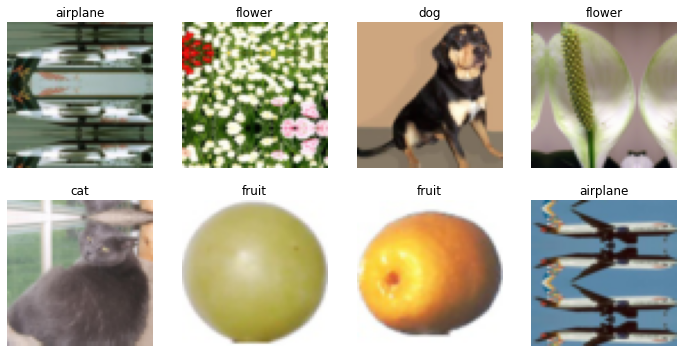

In [ ]:
loader.show_batch(max_n=8)

In [ ]:
learner = vision_learner(loader, resnet34, metrics=error_rate)


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
learner.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.849832,0.309907,0.105874,07:48


epoch,train_loss,valid_loss,error_rate,time
0,0.253590,0.158467,0.052937,05:32
1,0.133849,0.110014,0.035533,05:33
2,0.077344,0.098934,0.035533,05:38


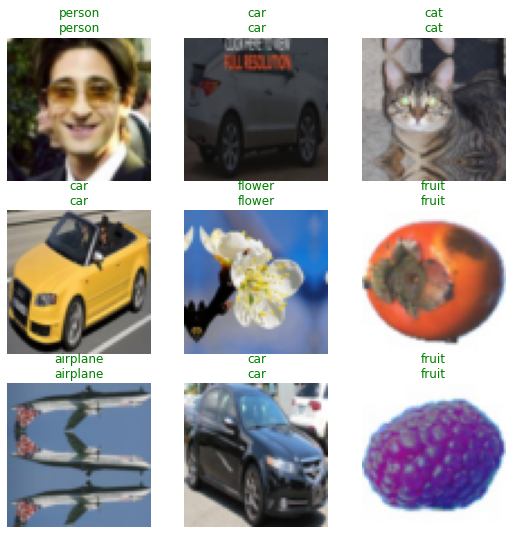

In [ ]:
learner.show_results()

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)

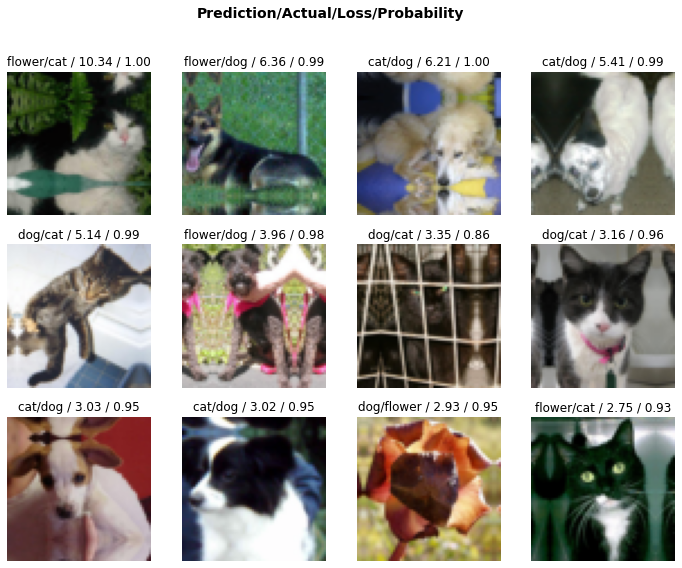

In [ ]:
interp.plot_top_losses(12)